In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from bgflow.utils import (assert_numpy, distance_vectors, distances_from_vectors,
                    remove_mean, IndexBatchIterator, LossReporter)

from bgflow import (GaussianMCMCSampler, SequentialFlow, BoltzmannGenerator, 
                    Energy, Sampler, MultiDoubleWellPotential, MeanFreeNormalDistribution, 
                    CouplingFlow, AffineTransformer, DenseNet, 
                    SequentialFlow, SwapFlow, SplitFlow, InverseFlow )
from bgflow.utils import RbfEncoder, kernelize_with_rbf, compute_gammas


In [3]:
# first define system dimensionality and a target energy/distribution

dim = 4
n_particles = 2
n_dof = dim // n_particles
# DW parameters
a=0.9
b=-4
c=0
offset=3


target = MultiDoubleWellPotential(dim, n_particles, a, b, c, offset)

In [4]:
prior =  MeanFreeNormalDistribution(dim, n_particles, 1)


In [5]:
# define a MCMC sampler to sample from the target energy

init_state = torch.Tensor([[1., 0, -1, 0]])
target_sampler = GaussianMCMCSampler(target, init_state=init_state, noise_std=0.4)

In [6]:
data = target_sampler.sample(50000)
data = data.reshape(-1, dim)
data  = remove_mean(data, n_particles, dim // n_particles)

In [7]:
latent = prior.sample(50000)

In [8]:
dists = distances_from_vectors(
            distance_vectors(data.view(-1, n_particles, dim // n_particles)))
dists_prior = distances_from_vectors(
            distance_vectors(latent.view(-1, n_particles, dim // n_particles)))

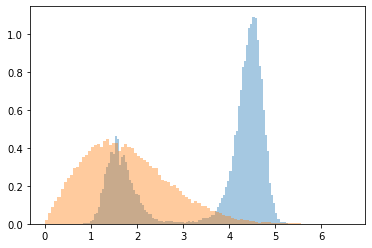

In [9]:
plt.hist(dists.view(-1), bins=100, alpha=0.4, density=True);
plt.hist(dists_prior.view(-1).cpu(), bins=100,alpha=0.4, density=True);

In [ ]:
# The equivaraint RNVP flow requires and invaraint scaling transformation 
# and an equivaraint translation transformation. Both wrt to rotations and permutations

class InvariantNet(torch.nn.Module):    
    def __init__(self, n_particles, n_dof, dist_net, encoder=None):
        super().__init__()
        self._dist_net = dist_net
        self._encoder = encoder
        self._n_particles = n_particles
        self._n_dof = n_dof    
    def forward(self, x):
        n_batch = x.shape[0]
        n_dim = self._n_particles * self._n_dof
        assert x.shape[-1] == n_dim
        x = x.view(n_batch, self._n_particles, self._n_dof)
        r = distance_vectors(x) 
        d = distances_from_vectors(r)
        if self._encoder is not None:
            d = self._encoder(d.unsqueeze(-1))
        d_shape = d.shape
        f = self._dist_net(d.view(-1, d_shape[-1]))
        f = f.view(*d_shape[:-1], -1)
        f = f.view(n_batch, -1).mean(dim=-1, keepdim=True) * torch.ones(n_batch, n_dim).cuda()
        return f
    
class EquivariantNet(torch.nn.Module):          
    def __init__(self, n_particles, n_dof, dist_net, encoder=None, remove_mean=True):
        super().__init__()
        self._dist_net = dist_net
        self._encoder = encoder
        self._invariant_net = dist_net
        self._n_particles = n_particles
        self._n_dof = n_dof
        self._remove_mean = remove_mean  
        
    def forward(self, x):
        n_batch = x.shape[0]
        x = x.view(n_batch, self._n_particles, self._n_dof)
        r = distance_vectors(x) 
        dist = distances_from_vectors(r)
        r = r / (dist.unsqueeze(-1) + 1e-3)
        if self._encoder is not None:
            d = self._encoder(dist.unsqueeze(-1)) 
        d_shape = d.shape
        f = self._dist_net(d.view(-1, d_shape[-1]))
        f = f.view(*d_shape[:-1], -1) #+ q
        f = (f * r).sum(dim=-2)
        if self._remove_mean:
            f = remove_mean(f, self._n_particles, self._n_dof)
        return f.view(n_batch, -1)

In [11]:
# Now we can define the equivariant RNVP flow



n_rbfs = 50
n_layers = 4

# shared distance embeddings across RNVP blocs 
kernel_mus = torch.linspace(0., 8., n_rbfs).cuda()
kernel_gammas = compute_gammas(kernel_mus, gain=0.5).cuda()
dist_encoder = RbfEncoder(kernel_mus, kernel_gammas.log(), trainable=True)

layers=[]

layers.append(SplitFlow(dim))

n_coupling_layers = 16
for _ in range(n_coupling_layers):
    
    # we need to swap dimensions for the mixing
    layers.append(SwapFlow())
    
    # now set up a coupling block
    layers.append(CouplingFlow(
        AffineTransformer(
                EquivariantNet(
                    n_particles, n_dof, DenseNet([n_rbfs, 64, 64, 1], torch.nn.ReLU()),
                    encoder=dist_encoder
                ),
                InvariantNet(
                    n_particles, n_dof, DenseNet([n_rbfs, 64, 64, 1], torch.nn.ReLU()),
                    encoder=dist_encoder
                ),

            )
        )
    )
    
# finally, we have to merge the two channels again into one tensor
layers.append(InverseFlow(SplitFlow(dim)))
    
# now define the flow as a sequence of all operations stored in layers
flow = SequentialFlow(layers).cuda()

In [12]:
# having a flow and a prior, we can now define a Boltzmann Generator


bg = BoltzmannGenerator(prior, flow, target)

In [13]:
# train with convex mixture of NLL and KL loss

n_kl_samples = 64
n_batch = 64
batch_iter = IndexBatchIterator(len(data), n_batch)

optim = torch.optim.Adam(bg.parameters(), lr=5e-4)

n_epochs = 10
n_report_steps = 50

# mixing parameter
lambdas = torch.linspace(1., 0.0, n_epochs).cuda()

reporter = LossReporter("NLL", "KLL")

In [14]:
for epoch, lamb in enumerate(lambdas):
    for it, idxs in enumerate(batch_iter):
        batch_data = data[idxs].cuda()
        batch_noise = prior.sample(batch_data.shape[0])
        batch = torch.cat([batch_data, batch_noise], dim=1)
        
        optim.zero_grad()

        # negative log-likelihood of the batch is equal to the energy of the BG
        
        latent_samples, latent_dlogp = flow(batch, inverse=True)
        nll = - 0.5 * latent_dlogp.mean() + prior.energy(latent_samples[:, dim:]).mean() + prior.energy(latent_samples[:, :dim]).mean()  
        nll.backward()
        
        # kl divergence to the target
        latent = torch.cat([prior.sample(n_kl_samples), prior.sample(n_kl_samples)], dim=1)
        samples, dlogp = flow(latent)

        kll = target.energy(samples[:, :dim]).mean() + prior.energy(samples[:, dim:]).mean() - 0.5 *  dlogp.mean()   

        # aggregate weighted gradient
        ((1. - lamb) * kll).backward()
        
        reporter.report(nll, kll)
        
        optim.step()
        
        if it % n_report_steps == 0:
            print("\repoch: {0}, iter: {1}/{2}, lambda: {3}, NLL: {4:.4}, KLL: {5:.4}".format(
                    epoch,
                    it,
                    len(batch_iter),
                    lamb,
                    *reporter.recent(1).ravel()
                ), end="")

epoch: 9, iter: 750/781, lambda: 0.0, NLL: 2.419, KLL: -2.53173, KLL: -2.818

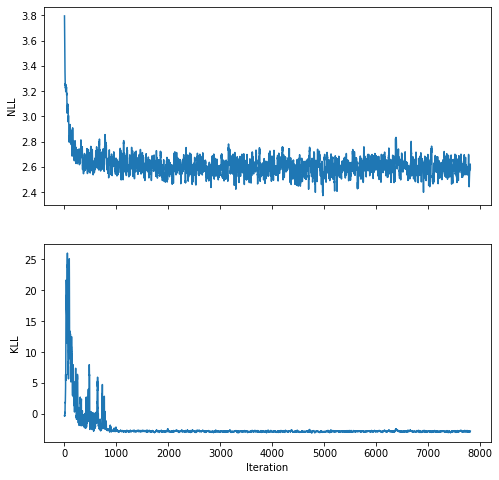

In [15]:
reporter.plot()

In [16]:
n_samples = 10000

latent = torch.cat([prior.sample(n_samples), prior.sample(n_samples)], dim=1)
samples, dlogp = flow(latent)

distances_x = distances_from_vectors(distance_vectors(samples[:, :dim].view(-1, n_particles, dim // n_particles))).view(-1).detach().cpu().numpy() 
distances_v = distances_from_vectors(distance_vectors(samples[:, dim:].view(-1, n_particles, dim // n_particles))).view(-1).detach().cpu().numpy() 

log_w = target.energy(samples[:, :dim]) + prior.energy(samples[:, dim:]) - 0.5 * dlogp  - prior.energy(latent[:, dim:]) - prior.energy(latent[:, :dim]) 




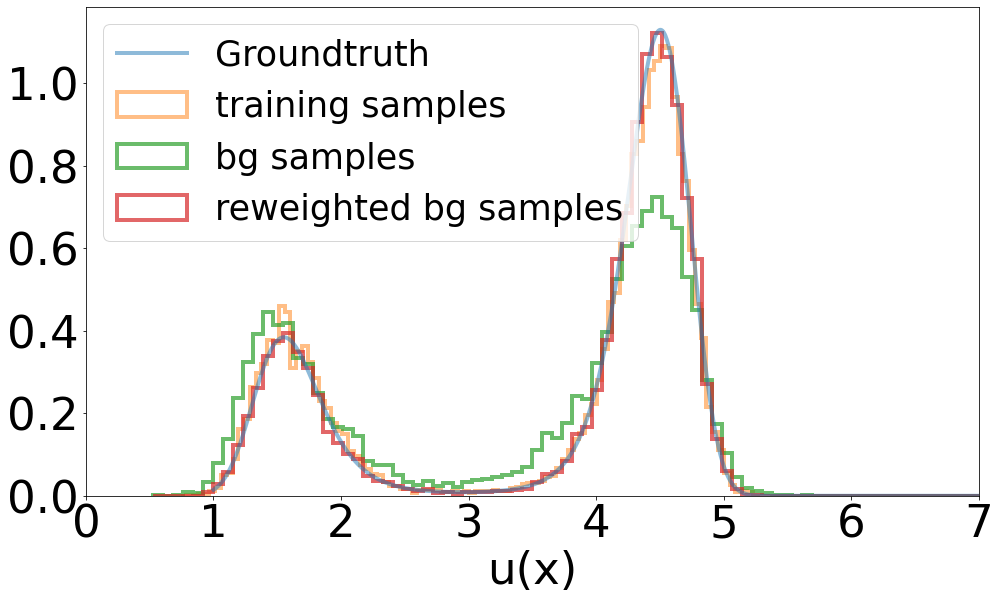

In [17]:
# distance of the dimer

def distance_energy(d):
    d = d - offset
    return a * d**4 + b * d**2
d = torch.linspace(1, 7, 1000).view(-1, 1) + 1e-6 
u = torch.exp(-(distance_energy(d).view(-1, 1) - offset )).sum(dim=-1, keepdim=True)  * d.abs() **(dim // n_particles - 1)
Z = (u * 1 / (len(d) / (d.max() - d.min()))).sum()
e = u / Z #* 1.1

plt.figure(figsize=(16,9))
plt.plot(d, e, label="Groundtruth", linewidth=4, alpha = 0.5)
plt.hist(dists.view(-1)[::2], bins=100, label="training samples", alpha=0.5, density=True, histtype='step', linewidth=4);
plt.hist(distances_x[::2], bins=100, label="bg samples", alpha=0.7, density=True, histtype='step', linewidth=4);
plt.hist(distances_x[::2], bins=100, label="reweighted bg samples", alpha=0.7, density=True, histtype='step', linewidth=4, weights=np.exp(-log_w.view(-1).cpu().detach()));
plt.xlim(0,7)
plt.legend(fontsize=35)
plt.xlabel("u(x)", fontsize=45)  
plt.xticks(fontsize=45) 
plt.yticks(fontsize=45);

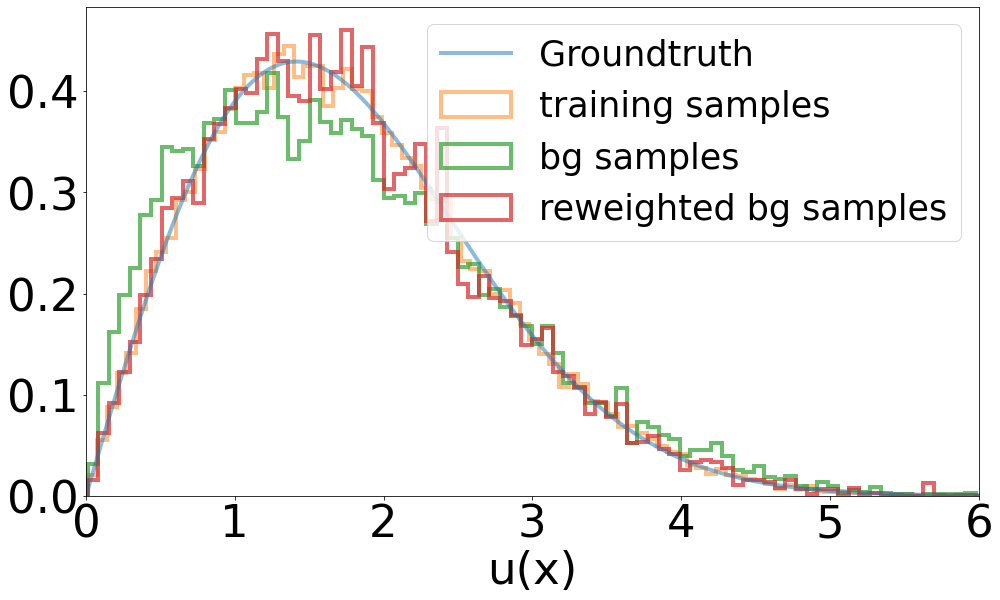

In [18]:
# distance of the velocities

def distance_energy_v(d):
    d = d 
    return 0.5 * d**2
d = torch.linspace(0, 6, 1000).view(-1, 1) + 1e-6 
u = torch.exp(-0.5 *(distance_energy_v(d).view(-1, 1) )).sum(dim=-1, keepdim=True)  * d.abs() **(dim // n_particles - 1)
Z = (u * 1 / (len(d) / (d.max() - d.min()))).sum()
e = u / Z #* 1.1

plt.figure(figsize=(16,9))
plt.plot(d, e, label="Groundtruth", linewidth=4, alpha = 0.5)
plt.hist(dists_prior.cpu().detach().view(-1)[::2], bins=100, label="training samples", alpha=0.5, density=True, histtype='step', linewidth=4);
plt.hist(distances_v[::2], bins=100, label="bg samples", alpha=0.7, density=True, histtype='step', linewidth=4);
plt.hist(distances_v[::2], bins=100, label="reweighted bg samples", alpha=0.7, density=True, histtype='step', linewidth=4, weights=np.exp(-log_w.view(-1).cpu().detach()));
plt.xlim(0,6)
plt.legend(fontsize=35)
plt.xlabel("u(x)", fontsize=45)  
plt.xticks(fontsize=45) 
plt.yticks(fontsize=45);

In [19]:
noise = prior.sample(10000)

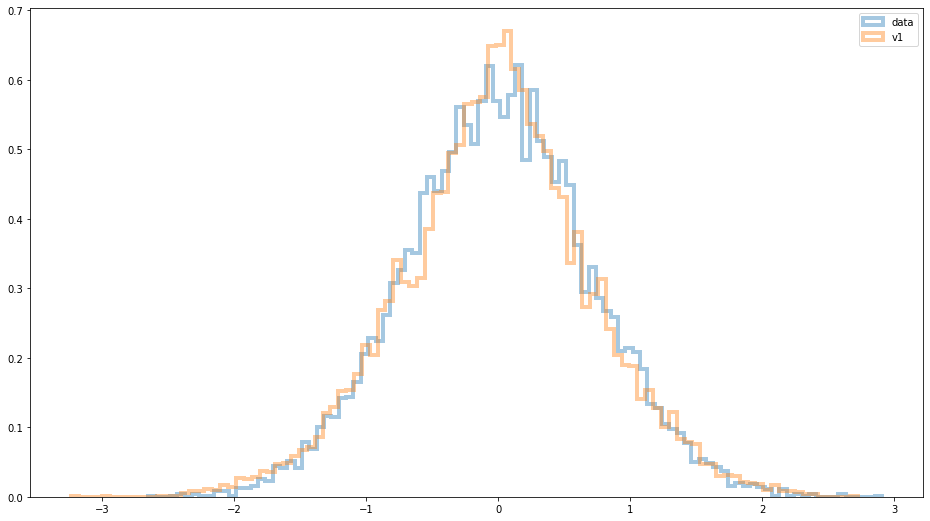

In [20]:
# energy of the samples velocities

def energy_v(d):
    d = d
    return  0.5 * d**2
dv = torch.linspace(-3, 3, 1000).view(-1, 1) + 1e-6 
ev = np.exp(- energy_v(dv)*2)/np.sqrt(np.pi) 

plt.figure(figsize=(16,9))
plt.hist(noise[:, 1].cpu().detach(), bins=100, label="data", alpha=0.4, density=True, histtype='step', linewidth=4);
plt.hist(samples[:, dim].cpu().detach(), bins=100, label="v1", alpha=0.4, density=True, histtype='step', linewidth=4);

plt.legend();

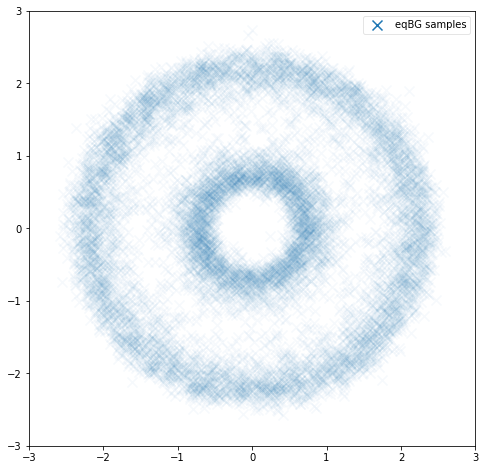

In [21]:
# configuration samples

plt.figure(figsize=(8,8))
plt.scatter(*samples.cpu().detach().numpy()[:, :2].T, s=100, alpha=0.04, marker="x", label="eqBG samples")
plt.xlim(-3, 3);
plt.ylim(-3, 3);

leg = plt.legend(framealpha=0.5)


for lh in leg.legendHandles: 
    lh.set_alpha(1)

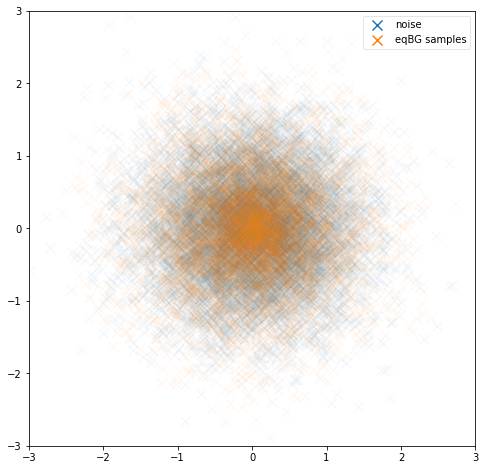

In [22]:
# velocity samples

plt.figure(figsize=(8,8))
plt.scatter(*noise.cpu().detach().numpy()[:, :2].T, s=100, alpha=0.04, marker="x", label="noise")
plt.scatter(*samples.cpu().detach().numpy()[:, 4:6].T, s=100, alpha=0.04, marker="x", label="eqBG samples")

plt.xlim(-3, 3);
plt.ylim(-3, 3);

leg = plt.legend(framealpha=0.5)


for lh in leg.legendHandles: 
    lh.set_alpha(1)

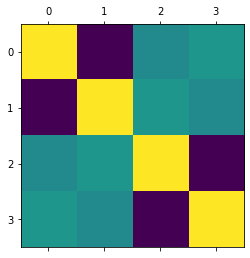

In [23]:
# correlationsof the x coordinates of the samples.
# Ideally there should not be any correlelations between the velocities and the configurations
correlations = np.corrcoef(samples[:,::2].cpu().detach().T)
plt.matshow(correlations);